In [2]:
import glob
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime
import sklearn.preprocessing as preproc
import sklearn.linear_model as lm
import sklearn.pipeline
from scipy.optimize import least_squares
from IPython.display import Image
%matplotlib inline

In [3]:
def load_registration_data(path = 'data/SOS/processed/voter-registration.csv'):
    df = pd.read_csv(path,header=[0,1],index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    df.sort_index(axis=1,level=[0,1],inplace=True)
    df.sort_index(axis=0,level=[0,1],inplace=True)
    # impute (by eye for now) the value for a spurious entry
    idx = pd.IndexSlice
    df.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']] = 46490
    df.loc[idx['Lake','Fraction'],idx['2008-04-04','Total Registered']] = (
        df.loc[idx['Lake','Count'],idx['2008-04-04','Total Registered']].values / 
        df.loc[idx['Lake','Count'],idx['2008-04-04','Eligible']].values)
    return df

def load_prop_data(path = 'data/SOS/processed/measures.csv'):
    df = pd.read_csv(path,header=[0,1,2],index_col=0)
    dtIdx = pd.DatetimeIndex(df.columns.get_level_values(0))
    col_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.columns.get_level_values(1),df.columns.get_level_values(2)])
    df.columns = col_mIdx
    df.sort_index(inplace=True,axis=1,level=[0,1])
    return df

def load_prop_metadata(path = 'data/SOS/processed/measures_metadata.csv'):
    df = pd.read_csv(path,header=0,index_col=[0,1])
    dtIdx = pd.DatetimeIndex(df.index.get_level_values(0))
    row_mIdx = pd.MultiIndex.from_arrays([dtIdx,df.index.get_level_values(1)])
    df.index = row_mIdx
    df.sort_index(inplace=True,axis=0)
    return df

In [4]:
df_reg = load_registration_data()
df_prop = load_prop_data()
df_prop_meta = load_prop_metadata()

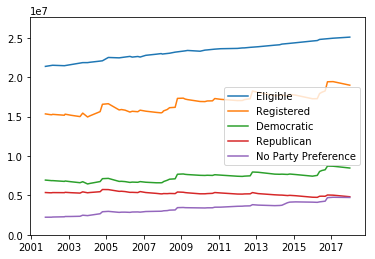

In [5]:
idx = pd.IndexSlice
county = 'State Total'
elg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Eligible']]
reg_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Total Registered']]
dem_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Democratic']]
rep_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Republican']]
grn_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'Green']]
npp_vs_time = df_reg.loc[idx[county,'Count'],idx[:,'No Party Preference']]
x = elg_vs_time.index.get_level_values('Date')
y = elg_vs_time.values
plt.plot(x,y,label='Eligible')
y = reg_vs_time.values
plt.plot(x,y,label='Registered')
y = dem_vs_time.values
plt.plot(x,y,label='Democratic')
y = rep_vs_time.values
plt.plot(x,y,label='Republican')
# y = grn_vs_time.values
# plt.plot(x,y,label='Green')
y = npp_vs_time.values
plt.plot(x,y,label='No Party Preference')
plt.ylim(0,1.1*max(elg_vs_time.values))
plt.legend()

In [6]:
# date lookup table
df_prop_meta['nearest_reg_date']= np.nan # initialize column

# for all prop election dates, find closest (prior) voter registration dataset
for prop_date in df_prop_meta.index.levels[0]:
    reg_dates = df_reg.columns.levels[0]
    reg_dates_delta = pd.Series(prop_date - reg_dates, index=reg_dates)
    idx_closest_before = reg_dates_delta[reg_dates_delta>pd.to_timedelta(0)].idxmin()
    # add to metadata table
    df_prop_meta.loc[prop_date,'nearest_reg_date'] = idx_closest_before
    #print('\nProp date:',prop_date)
    #print('Registration info date:',idx_closest_before)
    #print('Diff:',reg_dates_delta[idx_closest_before])


In [7]:
idx = pd.IndexSlice
df_prop_meta['R2'] = np.nan
df_prop_meta['std'] = np.nan
df_prop_meta['outliers'] = np.nan
df_prop_meta['num_outliers'] = np.nan

In [8]:
for ii in range(len(df_prop_meta)):
    #if ii != 125: continue
    meta_row = df_prop_meta.iloc[ii]


    # get the proposition metadata
    prop_descr  = meta_row['Description']
    prop_date = meta_row.name[0]
    prop_name = meta_row.name[1]
    elec_type = meta_row['Election_type']
    reg_date = meta_row['nearest_reg_date']

    # grab the voter registration data and proposition voting results
    # make sure to drop the state results rows for plots and calcs
    vote_yes = df_prop.loc[df_prop.index != 'State Totals',idx[prop_date,prop_name,'Yes']]
    vote_no = df_prop.loc[df_prop.index != 'State Totals',idx[prop_date,prop_name,'No']]
    yes_no_asym = (vote_yes-vote_no)/(vote_yes+vote_no)
    reg_dem = df_reg.loc[idx[:,'Count'],idx[reg_date,'Democratic']].drop('State Total')
    reg_rep = df_reg.loc[idx[:,'Count'],idx[reg_date,'Republican']].drop('State Total')
    rep_dem_asym = (reg_rep-reg_dem)/(reg_rep+reg_dem)
    reg_frac = df_reg.loc[idx[:,'Fraction'],idx[reg_date,'Total Registered']].drop('State Total')
    reg_tot = df_reg.loc[idx[:,'Count'],idx[reg_date,'Total Registered']].drop('State Total')
    elg_tot = df_reg.loc[idx[:,'Count'],idx[reg_date,'Eligible']].drop('State Total')
    elg_norm = 1+(elg_tot - elg_tot.min())/ (elg_tot.max()-elg_tot.min())
    non_trad_party = (reg_tot - (reg_dem + reg_rep))/reg_tot
    vote_yes_state = df_prop.loc['State Totals',idx[prop_date,prop_name,'Yes']]
    vote_no_state = df_prop.loc['State Totals',idx[prop_date,prop_name,'No']]
    yes_no_asym_state = (vote_yes_state-vote_no_state)/(vote_yes_state+vote_no_state)
    reg_dem_state = df_reg.loc[idx['State Total','Count'],idx[reg_date,'Democratic']]
    reg_rep_state = df_reg.loc[idx['State Total','Count'],idx[reg_date,'Republican']]
    rep_dem_asym_state = (reg_rep_state-reg_dem_state)/(reg_rep_state+reg_dem_state)
    df_prop_meta.loc[idx[prop_date,prop_name],'std'] = yes_no_asym.std()
    
    # fit a line
    model_OLS = lm.LinearRegression()
    model_OLS.fit(rep_dem_asym.values.reshape(-1,1),yes_no_asym)
    X_line = np.linspace(1.1*rep_dem_asym.min(),1.1*rep_dem_asym.max(),num=20).reshape(-1,1)
    y_OLS = model_OLS.predict(X_line)
    R2 = model_OLS.score(rep_dem_asym.values.reshape(-1,1),yes_no_asym)
    df_prop_meta.loc[idx[prop_date,prop_name],'R2'] = R2
    
    # find oultliers using interquartile range of the residuals distribution
    resid = yes_no_asym - model_OLS.predict(rep_dem_asym.values.reshape(-1,1))
    resid_standardized = pd.Series(preproc.scale(resid),index = resid.index)
    resid_standardized['State Totals'] = 0
    df_prop.loc[:,idx[prop_date,prop_name,'residual']] = resid_standardized
    Q1, Q3 = np.percentile(resid,[25,75])
    IQR = Q3 - Q1
    lo_thresh, hi_thresh = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    is_outlier = (resid < lo_thresh) | (resid > hi_thresh)
    edgecolors = np.array(['k']*len(is_outlier))
    edgecolors[is_outlier.values] = 'r'
    outliers = is_outlier[is_outlier].index.values
    outliers_str = ', '.join([outlier for outlier in outliers])
    df_prop_meta.loc[idx[prop_date,prop_name],'outliers'] = outliers_str
    df_prop_meta.loc[idx[prop_date,prop_name],'num_outliers'] = len(outliers)
    is_outlier['State Totals'] = False
    df_prop.loc[:,idx[prop_date,prop_name,'is_outlier']] = is_outlier
    
    
    # show the line and scatter-plot
    plt.figure(figsize=(8, 6), dpi= 240)
    plt.plot(X_line,y_OLS,alpha=0.7,color='k')
    plt.plot(X_line,y_OLS+Q3+1.5*IQR,alpha=0.7,color='grey',linestyle='--')
    plt.plot(X_line,y_OLS+Q1-1.5*IQR,alpha=0.7,color='grey',linestyle='--')
    plt.plot([-1,1],[yes_no_asym_state]*2,alpha=0.3,color='blue',linestyle='--')
    h_scatter = plt.scatter(rep_dem_asym,yes_no_asym,marker='o',c=non_trad_party,s=40*elg_norm**4,
                cmap=plt.get_cmap('Purples'),alpha=0.7,edgecolor=edgecolors)
    plt.scatter(rep_dem_asym_state, yes_no_asym_state, c='blue', marker='+')
    plt.title(str(prop_date.year) + ': ' + prop_name + '\n' + prop_descr)
    plt.xlabel('<---Dem            Rep--->')
    plt.ylabel('<---No         Yes--->')
    if len(outliers) > 0:
        text_str = '$R^2 = ${:.2f}\noutliers = {:s}'.format(R2,outliers_str)
    else:
        text_str = '$R^2 = ${:.2f}'.format(R2)
    plt.text(x=.95,y=.95,s=text_str,ha='right',va='top')
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    cbar = plt.colorbar(mappable=h_scatter,pad=0.02)
    cbar.ax.set_ylabel('Fraction of registered voters in non-Dem,Rep party')
    plt.savefig('plots/'+str(prop_date.year)+'-'+prop_name+'.png')
    plt.clf()
    
df_prop.sort_index(axis=1,level=[0,1,2],inplace=True)
df_prop_meta.sort_index(axis=1,level=1,inplace=True)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


![caption](plots/2016-Proposition_63.png)

![caption](plots/2012-Proposition_30.png)

![caption](plots/2010-Proposition_13.png)

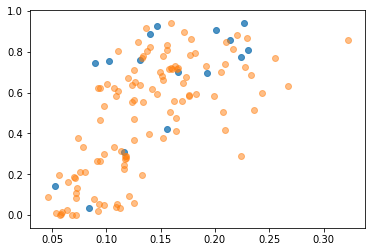

In [11]:
df_prop_meta['Descr_has_tax'] = df_prop_meta['Description'].map(lambda x: 'Tax' in x or 'tax' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_tax'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_tax'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_tax'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_tax'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)


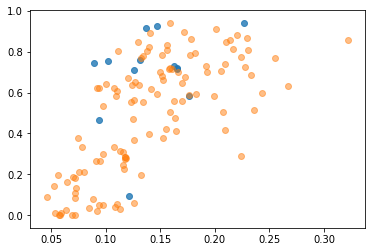

In [12]:
df_prop_meta['Descr_has_school'] = df_prop_meta['Description'].map(lambda x:
                                                                   'school' in x or
                                                                   'School' in x or
                                                                   'education' in x or
                                                                   'Education' in x or 
                                                                   'College' in x or 
                                                                   'college' in x or 
                                                                   'universit' in x or 
                                                                   'Universit' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_school'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_school'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_school'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_school'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

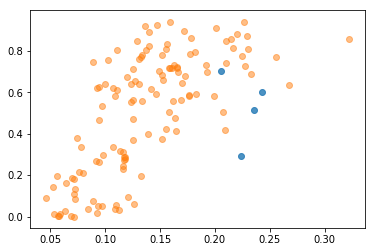

In [13]:
df_prop_meta['Descr_has_water'] = df_prop_meta['Description'].map(lambda x:
                                                                       'Water' in x or
                                                                       'water' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_water'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_water'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_water'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_water'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

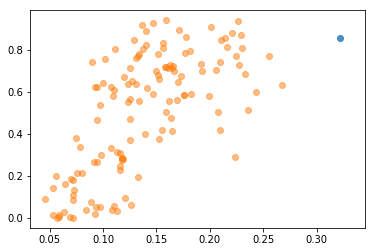

In [14]:
df_prop_meta['Descr_has_gun'] = df_prop_meta['Description'].map(lambda x:
                                                                       'Gun' in x or
                                                                       'gun' in x or
                                                                   'firearm' in x or
                                                                   'Firearm' in x or
                                                                    'Weapon' in x or
                                                                    'weapon' in x)
x1 = df_prop_meta.loc[df_prop_meta['Descr_has_gun'],'std']
y1 = df_prop_meta.loc[df_prop_meta['Descr_has_gun'],'R2']
x2 = df_prop_meta.loc[~df_prop_meta['Descr_has_gun'],'std']
y2 = df_prop_meta.loc[~df_prop_meta['Descr_has_gun'],'R2']
plt.scatter(x1,y1,alpha=0.8)
plt.scatter(x2,y2,alpha=0.5)

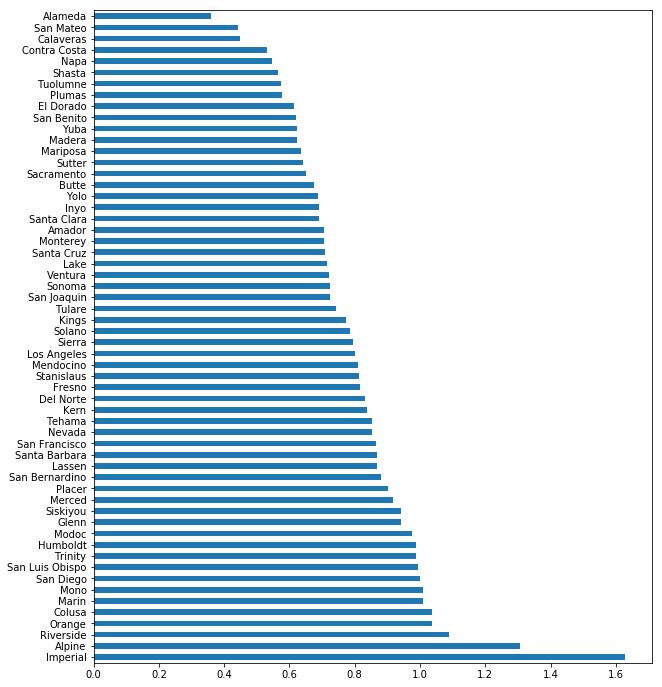

In [18]:
plt.figure(figsize=(10, 12))
df_prop.sort_index(axis=1,level=[0,1,2],inplace=True)
np.abs(df_prop.loc[df_prop.index != 'State Totals',
                   idx[:,:,'residual']]).T.mean().sort_values(ascending=False).plot(kind='barh')
plt.title('Mean residual ')

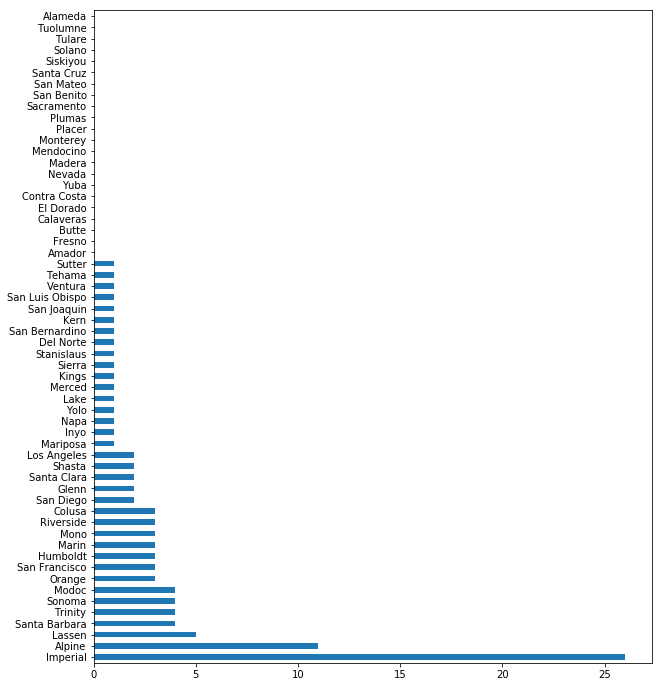

In [19]:
plt.figure(figsize=(10, 12))
(df_prop.loc[df_prop.index != 'State Totals',idx[:,:,'is_outlier']]).T.sum().sort_values(ascending=False).plot(kind = 'barh')